In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train_data = torch.load('/project/annotation/train_forScore.pt')
test_data = torch.load('/project/annotation/test_forScore.pt')
valid_data = torch.load('/project/annotation/valid_forScore.pt')

In [4]:
# dataloaders
batch_size = 32
device='cuda'

# make sure to SHUFFLE for your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [5]:
import torch.nn as nn

class SentimentLSTM(nn.Module):

    def __init__(self, seq_size, output_size, hidden_dim, n_layers):
        
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.lstm = nn.LSTM(seq_size, hidden_dim, n_layers, batch_first=True, dropout=0.2)
        
        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        
        lstm_out, hidden = self.lstm(x)
        ## lstm_out.shape [batch, seq_len, hidden_dim]
        ## hidden [batch, hidden_dim]

        # fully connected layer        
        out = self.fc(lstm_out[:, -1, :])
        ## out.shape: [n_layer * n_direction, batch, output_size]

        # sigmoid function
        sig_out = self.sig(out)
        
        # return last sigmoid output and hidden state
        return sig_out, out

In [6]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        # nn.init.uniform_(param.data, -0.1, 0.1)
        

In [7]:
hidden_dim = 512
n_layers = 4
lr = 0.01
output_size = 1

model = SentimentLSTM(20, output_size, hidden_dim, n_layers)
model.to('cuda')
model.apply(init_weights)


SentimentLSTM(
  (lstm): LSTM(20, 512, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss().cuda()

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

In [9]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
train_losses = []
valid_losses = []
num_epochs = 7
device = 'cuda'
m = nn.Softmax(dim = 1)

for epoch in tqdm(range(num_epochs+1)): 
    # train

    losses = []
    for i, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.cuda(), target.cuda()

        model.train()
        optimizer.zero_grad()
        
        outputs, hidden = model(inputs)


        # print(f'target shape: {target.shape}')
        # print(f'outputs shape: {outputs.shape}')
        # print(outputs[0])
        # print(target[0])
        loss = criterion(outputs.squeeze(), target.float())
        loss.backward()

        # scheduler.step()
        # torch.nn.utils.clip_grad_norm_(lstm.parameters(), 10)

        optimizer.step()
        losses.append(loss.item())
    scheduler.step()

    train_losses.append(np.mean(np.array(losses)))

    losses = []
    for i, (inputs, target) in enumerate(valid_loader):
        inputs, target = inputs.cuda(), target.cuda()

        model.eval()
        valid, hidden = model(inputs)

        #inverse
        # valid = torch.from_numpy(scaler.inverse_transform(valid.cpu().detach().numpy()))


        vall_loss = criterion(valid.squeeze(), target.float())
        # scheduler.step(vall_loss)
        losses.append(vall_loss.item())

    valid_losses.append(np.mean(np.array(losses)))
    
    
    if epoch % 2 == 0:
        # print(criterion1(outputs, y_train.to(device),quantile))

        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
                                                                        optimizer.param_groups[0]["lr"]))

    torch.save(model.state_dict(), './model_weight.pth')
    # model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

    # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
    # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
    early_stopping(valid_losses, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    """
    early_stopping(round(valid_losses[-1],5), model)

    if early_stopping.early_stop:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
                                                                      optimizer.param_groups[0]["lr"]))
        break
    """

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
losses = []
val1 = None
tor1 = None
for i, (input, target) in enumerate(test_loader):
    
    input, target = input.cuda(), target.cuda()

    model.eval()
    valid, hidden = model(input.to(device))
    

    #inverse
    # valid = torch.from_numpy(scaler.inverse_transform(valid.cpu().detach().numpy()))

    vall_loss = criterion(valid.squeeze(), target.float())
    val1 = valid
    tor1 = target.type(torch.long).to(device)
    # scheduler.step(vall_loss)
    losses.append(vall_loss.item())
    

#valid_losses.append(np.mean(np.array(losses)))

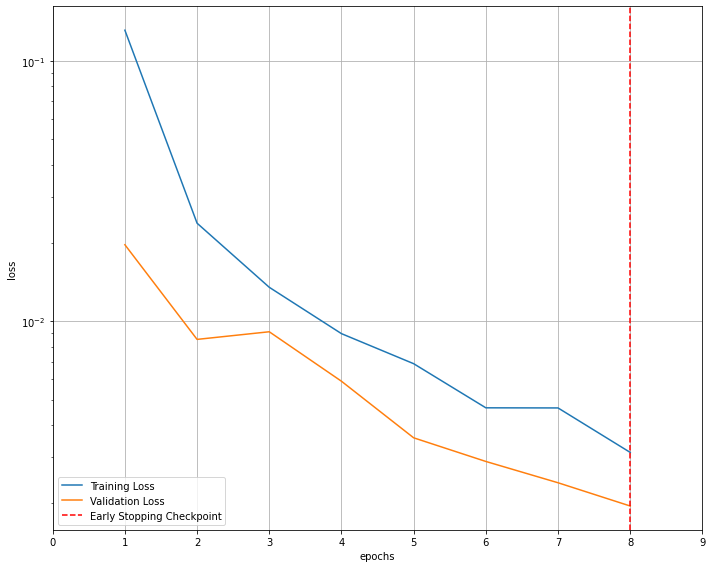

In [25]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1),valid_losses,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # 일정한 scale
plt.xlim(0, len(train_losses)+1) # 일정한 scale
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [12]:
print(tor1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


In [11]:
vall_loss = criterion(val1.squeeze(), tor1.float())

In [12]:
print(vall_loss)

tensor(0.1368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [13]:
print(len(losses))

632


In [14]:
print(len(test_data))

20216


In [14]:
def train(model, train_loader, valid_loader, criterion, optimizer,
          epochs = 4, print_every = 1000, clip=5):
    counter = 0

    # move model to GPU, if available

    model.train()
    # train for some number of epochs
    for e in range(epochs):
      # batch loop
        for inputs, labels in train_loader:
            counter += 1

            inputs, labels = inputs.cuda(), labels.cuda()

            # zero accumulated gradients
            model.zero_grad()

            # get the output from the model
            output, h = model(inputs)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_losses = []
                model.eval()
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.cuda(), labels.cuda()

                    output, val_h = model(inputs)
                    val_loss = criterion(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())

                model.train()
                print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()),
                    "Val Loss: {:.6f}".format(np.mean(val_losses)))

In [15]:
train(model, train_loader, valid_loader, criterion, optimizer)

Epoch: 1/4... Step: 1000... Loss: 0.713335... Val Loss: 0.665098
Epoch: 1/4... Step: 2000... Loss: 0.665361... Val Loss: 0.667735
Epoch: 1/4... Step: 3000... Loss: 0.697498... Val Loss: 0.680759
Epoch: 1/4... Step: 4000... Loss: 0.680513... Val Loss: 0.668773
Epoch: 1/4... Step: 5000... Loss: 0.647701... Val Loss: 0.657261
Epoch: 1/4... Step: 6000... Loss: 0.644167... Val Loss: 0.657255
Epoch: 1/4... Step: 7000... Loss: 0.622219... Val Loss: 0.663902
Epoch: 2/4... Step: 8000... Loss: 0.679453... Val Loss: 0.661010
Epoch: 2/4... Step: 9000... Loss: 0.582800... Val Loss: 0.676661
Epoch: 2/4... Step: 10000... Loss: 0.775414... Val Loss: 0.687700
Epoch: 2/4... Step: 11000... Loss: 0.627910... Val Loss: 0.657226
Epoch: 2/4... Step: 12000... Loss: 0.676351... Val Loss: 0.666580
Epoch: 2/4... Step: 13000... Loss: 0.667362... Val Loss: 0.705565
Epoch: 2/4... Step: 14000... Loss: 0.632252... Val Loss: 0.657484
Epoch: 2/4... Step: 15000... Loss: 0.530082... Val Loss: 0.682073
Epoch: 3/4... Step:

In [53]:
from sklearn.metrics import f1_score

def predict(model, test_loader, sequence_length=30):
    
    model.eval()
    
    batch_size = 32
    acc_list = list()
    pred_list, label_list = list(), list()
    
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        output, h = model(inputs)
        
        pred = torch.round(output.squeeze())
        
        #print(f1_score(pred, labels))
        
        accuracy = (pred==labels).sum().item() / 32
        acc_list.append(accuracy)
        
        pred = list(pred.cpu().detach().numpy())
        pred_list = pred_list + pred
        label_list += labels.cpu().numpy()

        #print('Prediction value, pre-rounding: ', output.item())

        # print custom response based on whether test_review is pos/neg
    pred_np = np.array(pred_list)
    label_np = np.array(label_list)
    
    print(pred_np.shape)
    print(label_np.shape)
    print(pred_np)
        
    print(np.mean(acc_list))
    print(f1_score(pred_np, label_np))

In [54]:
predict(model, test_loader)

ValueError: operands could not be broadcast together with shapes (0,) (32,) 